In [235]:
import networkx as nx
from typing import Literal, List, Tuple
from qiskit import QuantumCircuit, transpile
import numpy as np
import matplotlib.pyplot as plt
from qiskit.circuit import ParameterVector
from collections import defaultdict
from iqm.qiskit_iqm import IQMProvider, transpile_to_IQM
import os 

api_token = os.environ.get('RESONANCE_API_TOKEN')


# server_url = "https://cocos.resonance.meetiqm.com/emerald"
server_url = "https://cocos.resonance.meetiqm.com/sirius"

backend = IQMProvider(server_url, token=api_token).get_backend() 

In [25]:
def full_qaoa_ibm(G, layers, sorted_gates, fractional_gates=False):
    """
    Constructs a QAOA (Quantum Approximate Optimization Algorithm) circuit for MaxCut 
    on IBM Quantum hardware.

    Parameters:
    - G: networkx.Graph
        The input graph for the MaxCut problem.
    - layers: int
        The number of QAOA layers (p).
    - sorted_gates: list of lists
        A precomputed list of edges sorted into different gate execution groups.
    - fractional_gates: bool (default=False)
        If True, uses fractional RZZ gates; otherwise, uses CX-RZ-CX decomposition.

    Returns:
    - qc: QuantumCircuit
        The constructed quantum circuit for QAOA.
    """

    # Define parameter vectors for QAOA angles
    betas = ParameterVector("betas", layers)  # Mixing angles
    gammas = ParameterVector("gamma", layers)  # Cost function angles

    # Get the number of nodes in the graph
    nodes = G.number_of_nodes()

    # Extract edge weights (default to 1 if not weighted)
    if nx.is_weighted(G):
        weights = {(i, j): G[i][j]["weight"] for i, j in G.edges}
    else:
        weights = {(i, j): 1 for i, j in G.edges}

    # Initialize a quantum circuit with 'nodes' qubits
    qc = QuantumCircuit(nodes)

    # Apply Hadamard gates to all qubits to create a superposition state
    qc.h(range(nodes))

    # Apply QAOA layers
    for p in range(layers):
        # Apply cost function unitary for each edge in the graph
        for edge_group in sorted_gates:  # Iterate over the different gate execution groups
            for i, j in G.edges():
                qbits = [i, j]
                if (list(reversed(qbits)) in edge_group or qbits in edge_group):
                    if fractional_gates:
                        # Use the RZZ gate directly if fractional gates are allowed
                        qc.rzz(2 * gammas[p] * round(weights[i, j], 4), *qbits)
                    else:
                        # Standard QAOA implementation with CX and RZ gates
                        qc.cx(*qbits)
                        qc.rz(2 * gammas[p] * round(weights[i, j], 4), j)
                        qc.cx(*qbits)

        # Apply mixing unitary using RX rotations
        qc.rx(-2 * betas[p], range(nodes))

    # Measure all qubits at the end
    qc.measure_all()

    return qc

In [47]:
def cost_maxcut(bitstring, G):
    """
    Computes the cost of a given bitstring solution for the Max-Cut problem.

    Parameters:
    bitstring (str): A binary string representing a partition of the graph nodes (e.g., "1010").
    weights (dict): A dictionary where keys are edge tuples (i, j) and values are edge weights.

    Returns:
    float: The computed cost of the Max-Cut solution.
    """
    cost = 0  # Initialize the cost
    pos_bitstring = {j:i for i, j in enumerate(sorted(G.nodes()))}
    # Iterate through all edges in the graph
    for i, j in G.edges():
        # Check if the nodes i and j are in different partitions (cut condition)
        if bitstring[pos_bitstring[i]] + bitstring[pos_bitstring[j]] in ["10", "01"]:
            cost += G[i][j]["weight"]  # Add the edge weight to the cost

    return cost  # Return the total cut cost


def objective_MaxCut(samples_dict, G, optimal):
    """
    Evaluates the performance of a quantum algorithm for the Max-Cut problem.

    Parameters:
    samples_dict (dict): A dictionary where keys are bitstrings (binary solutions), 
                         and values are their occurrence counts.
    G (networkx.Graph): The input weighted graph where edges represent cut costs.
    optimal (str): The optimal bitstring solution found by classical solvers (e.g., CPLEX).

    Returns:
    dict: A dictionary containing:
        - "results": A numpy array with computed cost, normalized cost ratio, and counts.
        - "G": The input graph G.
        - "weights": The edge weights extracted from G.
        - "max_cut": The cost of the optimal Max-Cut solution.
        - "r": The expected approximation ratio.
        - "probability": The probability of sampling the optimal solution.
    """

    # Extract weights from the graph's edges
    weights = {(i, j): (G[i][j]["weight"] if len(G[i][j]) != 0 else 1) for i, j in G.edges}
    
    # Compute the cost of the optimal Max-Cut solution
    max_cost = cost_maxcut(optimal, G)

    results = []  # Stores results in the form [cost, ratio, counts]
    probability = 0  # Tracks probability of sampling the optimal solution

    # Iterate through all sampled bitstrings
    for bitstring, counts in samples_dict.items():
        cost = cost_maxcut(bitstring, G)  # Compute cost of the given bitstring
        r = cost / max_cost  # Compute the cost ratio relative to the optimal solution
        results.append([cost, r, counts])  # Store results
        
        # If this bitstring matches the optimal cost, update probability
        if abs(cost - max_cost) < 1e-6:
            probability += counts
        
        # Check if a better-than-optimal solution appears (sanity check)
        if cost > max_cost and cost - max_cost > 1e-10:
            print(f"There is a better cost than that of CPLEX: {cost - max_cost}")

    # Convert results to a NumPy array for easy computation
    results = np.array(results)

    # Total number of shots (total sampled solutions)
    shots = np.sum(results[:, 2])

    # Compute the expected approximation ratio: (weighted sum of costs) / (shots * max_cost)
    rT = np.sum(results[:, 0] * results[:, 2]) / (shots * max_cost)

    # Normalize the probability of sampling the optimal solution
    probability /= shots

    # Return results in a structured dictionary
    return {
        "results": np.array(results),
        "G": G,
        "weights": weights,
        "max_cut": max_cost,
        "r": rT,
        "probability": probability
    }

def mitigate(samples_dict, G, random=False):
    """
    Applies error mitigation by flipping individual bits in sampled solutions 
    to find better Max-Cut solutions.

    Parameters:
    samples_dict (dict): A dictionary where keys are bitstrings (binary solutions), 
                         and values are their occurrence counts.
    G (networkx.Graph): The input weighted graph where edges represent cut costs.
    random (bool, optional): If True, randomizes the order in which qubits are flipped.
                             Default is False (systematic flipping).

    Returns:
    dict: A dictionary of improved bitstring samples with their updated counts.
    """

    # Define a mapping to flip bits ('0' -> '1', '1' -> '0')
    change = {"0": "1", "1": "0"}

    # Get the number of nodes (qubits)
    nq = G.number_of_nodes()

    # Extract weights from the graph's edges
    weights = {(i, j): (G[i][j]["weight"] if len(G[i][j]) != 0 else 1) for i, j in G.edges}

    # Dictionary to store new (improved) samples
    new_samples = defaultdict(int)

    # Iterate over all bitstring samples
    for bitstring, counts in samples_dict.items():
        for _ in range(counts):  # Process each occurrence of the bitstring separately
            best_string = bitstring  # Initialize the best solution as the current one
            best_cost = cost_maxcut(bitstring, G)  # Compute its cost
            
            # Create an ordered list of qubits (nodes) to consider flipping
            list_qubits = np.arange(nq)
            
            # If random flipping is enabled, shuffle the qubit order
            if random:
                np.random.shuffle(list_qubits)

            # Try flipping each qubit and check if the cost improves
            for qi in list_qubits:
                # Flip the bit at position qi
                new_string = "".join((change[i] if n == qi else i) for n, i in enumerate(best_string))
                new_cost = cost_maxcut(new_string, G)

                # If the new configuration gives a better cost, update the best solution
                if new_cost > best_cost:
                    best_string = new_string
                    best_cost = new_cost
            
            # Store the improved bitstring in the new_samples dictionary
            new_samples[best_string] += 1

    return new_samples  # Return the mitigated samples

def random_samples(num_samples, n_qubits):
    """
    Generates random bitstring samples for a given number of qubits.

    Parameters:
    num_samples (int): The number of random bitstrings to generate.
    n_qubits (int): The number of qubits (length of each bitstring).

    Returns:
    dict: A dictionary where keys are randomly generated bitstrings 
          and values are their occurrence counts.
    """
    
    random_samples = defaultdict(int)  # Dictionary to store bitstrings and their counts

    # Generate random bitstrings and count their occurrences
    for _ in range(num_samples):
        bitstring = "".join(str(i) for i in np.random.choice([0, 1], n_qubits))  # Generate a random bitstring
        random_samples[bitstring] += 1  # Increment count for the generated bitstring

    return random_samples  # Return the dictionary of samples


In [16]:
def distribute_edges(graph: nx.Graph) -> list:
    """Distribute edges of a graph into layers, so not two edges in a layer share a node.
       This is needed for optimal circuit depth in a layer of QAOA circuit.
    Args:
        graph: Networkx graph of the problem.
    Returns:
        A list of layers, where each layer contains edges that are connected to nodes of the same degree.
    """
    # Get the maximum degree of the graph
    max_degree = max(dict(graph.degree()).values())
    layers: List[List[Tuple[int, int]]] = [[] for _ in range(max_degree)]
    edges_label = {n: edge for n, edge in enumerate(graph.edges())}
    n_edges = len(edges_label.keys())

    edges_graph = nx.Graph()
    edges_graph.add_nodes_from(edges_label.keys())
    for i in range(n_edges):
        for j in range(i + 1, n_edges):
            # Check if edges share a node and add them to the graph if they do
            if edges_label[i][0] in edges_label[j] or edges_label[i][1] in edges_label[j]:
                edges_graph.add_edges_from([[i, j]])
    # Use greedy coloring to distribute edges into layers
    # Each color represents a layer, where no two edges in the same layer share a node
    colors = nx.greedy_color(edges_graph, strategy="connected_sequential_bfs")
    for node, color in colors.items():
        layers[color].append(list(sorted(edges_label[node])))
    if sum(len(layer) for layer in layers) != n_edges:
        raise ValueError("Not all edges were assigned to a layer, check the graph structure.")
    return layers


In [252]:
import json
backend_name = "iqm_sirius"
edges = list(backend._coupling_map)
# with open(f"./Data/{backend_name}/native_layout.json", "w") as file:
        # json.dump(edges, file)

In [11]:
import numpy as np
import networkx as nx

In [ ]:
# chain_1D = [1,2,6,7,13,14,22,30,31,39,38,46,45,51,50,54,53,49,43,44,36,37,29,21,20,12,11,5,4,10,18,19,27,35,34,42,48,47,41,33,25,17,9,8,16,15,23,24,32,40]
chain_1D = [1,2,6,12,13,14,22,30,31,39,38,46,45,51,50,54,53,52,48,42,43,35,36,37,29,21,20,28,27,19,11,5,4,10,18,26,34,33,32,24,23,15,16,17,9,3]
edges = [tuple(sorted([chain_1D[i]-1, chain_1D[i+1]-1])) for i in range(len(chain_1D)-1)]
import json
backend_name = "iqm_sirius"
edges = list(backend._coupling_map)
# with open(f"./Data/{backend_name}/native_layout.json", "w") as file:
        # json.dump(edges, file)

In [ ]:
problems = np.load(f"./Data/NL-problems.npy", allow_pickle=True).item()

results = {}
SHOTS = 100
extra = "_5"
processor_type = "iqm_emerald"
# Define the list of QAOA layers (p-values)
ps = [3,5,7,10]
# Store the graph problem and solutions for the selected processor
results["G"] = problems[processor_type]["G"]  # Graph instance
results["sols"] = problems[processor_type]["sol"]  # Optimal solutions

# Store problem metadata
results["nq"] = results["G"].number_of_nodes()  # Number of qubits (nodes in the graph)
results["shots"] = SHOTS  # Number of measurement shots
results["ps"] = ps  # List of QAOA layers

results["G"] = problems[processor_type]["G"]  # Graph instance
results["sols"] = problems[processor_type]["sol"]  # Optimal solutions

# Store problem metadata
results["nq"] = results["G"].number_of_nodes()  # Number of qubits (nodes in the graph)
results["ps"] = ps  # List of QAOA layers

# Retrieve backend specifications
layers = distribute_edges(results["G"])  # Hardware-efficient layers

# Dictionary to store transpiled circuits
transpile_circs = {}

# Iterate over each QAOA depth (p)
for p in ps:
    print(f"Layer: -------  {p} ----------- ")

    # Generate QAOA circuit for the given depth
    qc = full_qaoa_ibm(results["G"], p, layers, fractional_gates=True)

    # Transpile the circuit for the target backend
    circ = transpile_to_IQM(qc, backend)

    # Store transpiled circuit
    transpile_circs[p] = circ

# List to store final parameterized circuits
circuits = []

# Define delta values for parameter tuning
# deltas = np.linspace(0.5, 1.5, 10)  # Uncomment for multiple delta values
# deltas = [1]  # Used for most experiments

deltas = [0.75]  # Used only for fractional gates
results["Deltas"] = deltas  # Store delta values in results

# Iterate over each delta and QAOA depth
for delta in deltas:
    for p in ps:
        print(f"Layer: -------  {p} ----------- ")

        # Compute beta and gamma parameters
        betas = np.round(np.arange(1, p+1)[::-1] * delta/p, 4)
        gammas = np.round(np.arange(1, p+1) * delta/p, 4)

        # Assign computed parameters to the transpiled circuit
        trans_circ = transpile_circs[p].assign_parameters(np.concatenate((betas, gammas)))

        # Store final circuit in the list
        circuits.append(trans_circ)




Layer: -------  5 ----------- 
Layer: -------  7 ----------- 
Layer: -------  10 ----------- 
Layer: -------  5 ----------- 
Layer: -------  7 ----------- 
Layer: -------  10 ----------- 


In [163]:
job = backend.run(circuits, shots=SHOTS) 

# Store the job ID to track and retrieve results later
results["id"] = job.job_id()  


# Save the results dictionary as a NumPy file for later analysis
np.save(f"./Data/{backend_name}/{results['nq']}_NL{extra}.npy", results)

In [164]:
# Define the number of qubits and backend for the experiment
n_qubits = 54
backend_name = "iqm_emerald"

# Specify an extra tag for identifying different versions of results

# Load previously saved results from a NumPy file
results = np.load(f"./Data/{backend_name}/{n_qubits}_NL{extra}.npy", allow_pickle=True).item()

# Retrieve job results from IBM Quantum Service using the stored job ID
jobs = backend.retrieve_job(job_id=results["id"]).result()

# Extract measurement results from the job
# The `.meas.get_counts()` method retrieves the bitstring results of each circuit execution
samples_dict = jobs.get_counts()

# Process and store the results:
# - Reverse the bitstring keys (k[::-1]) for compatibility
# - Organize data based on deltas and p-values (QAOA layers)
results["samples"] = {
    delta: {
        p: {k[::-1]: v for k, v in samples_dict[i + nd * len(results["ps"])].items()}
        for i, p in enumerate(results["ps"])
    }
    for nd, delta in enumerate(results["Deltas"])
}


In [165]:
postprocessing = {}
postprocessing_mitig = {}
for delta in results["samples"]:
    postprocessing[delta] = {}
    postprocessing_mitig[delta] = {}
    for p in results["samples"][delta]:
        print(f" -----------  {p}   ---------")
        postprocessing[delta][p] = objective_MaxCut(results["samples"][delta][p], results["G"], results["sols"])
        new_samples = mitigate(results["samples"][delta][p], results["G"], random=True)
        postprocessing_mitig[delta][p] = objective_MaxCut(new_samples, results["G"], results["sols"])
results["postprocessing"] = postprocessing
results["postprocessing_mitig"] = postprocessing_mitig
rand_samples = random_samples(1000, n_qubits)
results["random"] = objective_MaxCut(rand_samples, results["G"], results["sols"])
results["random_mitig"] = objective_MaxCut(mitigate(rand_samples, results["G"], random=True), results["G"], results["sols"])

np.save(f"./Data/{backend_name}/{n_qubits}_NL{extra}.npy", results)

 -----------  5   ---------
 -----------  7   ---------
 -----------  10   ---------


max approx. ratio 0.6401949860724234


Text(0.5, 0, 'p')

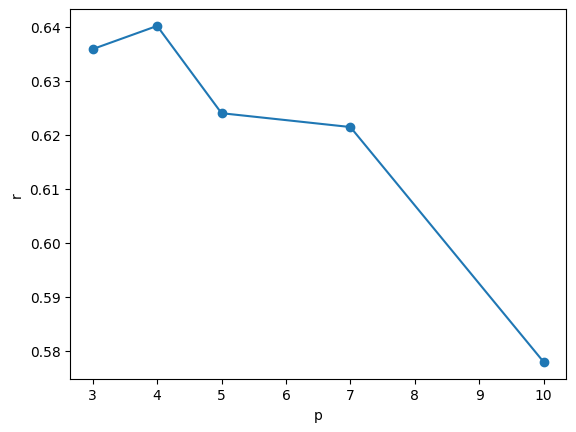

In [176]:
import matplotlib.pyplot as plt
extra = "_4"
results = np.load(f"./Data/{backend_name}/{n_qubits}_NL_T2.npy", allow_pickle=True).item()

fig, ax = plt.subplots()
delta = results["Deltas"][0]
ax.plot(results["postprocessing"][delta].keys(), [results["postprocessing"][delta][p]["r"] for p in results["postprocessing"][delta].keys()], marker="o")
print(f'max approx. ratio {max([results["postprocessing"][delta][p]["r"] for p in results["postprocessing"][delta].keys()])}')
ax.set_ylabel("r")
ax.set_xlabel("p")

In [173]:
extra = "_4"
results = np.load(f"./Data/{backend_name}/{n_qubits}_NL{extra}.npy", allow_pickle=True).item()
results_1 = np.load(f"./Data/{backend_name}/{n_qubits}_NL_5.npy", allow_pickle=True).item()
results["ps"] += results_1["ps"]
results["id"] = [results["id"], results_1["id"]]

for k,v in results_1["postprocessing"][0.75].items():
    results["postprocessing"][0.75][k] = v

In [175]:
np.save(f"./Data/{backend_name}/{n_qubits}_NL_T2.npy", results)